In [1]:
#For a prime power q and a number e,
#this program computes all chain rings with residue field k
#and ramification index e (i.e. (p)=m^e),
#up to isomorphism respecting the augmentation.
#Every chain ring R is represented by its length n and a choice of
#Eisenstein polynomial E, with R=W(k)[z]/(E(z),z^n).
#This representation is of course not unique and depends on a choice
#of uniformizer. Our conventions are such that the chosen uniformizer
#for a given tree always maps to the chosen uniformizers
#for all of its quotients. In particular, if two chain rings R, R' have
#isomorphic length n quotients R/m^n and R'/m^n, with our conventions
#their Eisenstein polynomials will agree modulo valuation n/e, i.e.
#the coefficient in front of z^i will agree modulo p^((n-i)//e)

In [2]:
def nextDisks(R,n,disks,z):
    pi = R.uniformiser()
    newDisks = []
    for disk in disks:
        polynomialReduced = disk["polynomial"].change_ring(R.residue_field())
        #other case: polynomialReduced == 0
        if polynomialReduced.is_zero():
            newdisk = dict(center = disk["center"], polynomial = disk["polynomial"]/pi, size=disk["size"])
            newDisks.append(newdisk)
        else:     
            for root,_ in polynomialReduced.roots():
                rootlift = R(root).lift_to_precision()
                newpoly = disk["polynomial"](pi*z+rootlift)/pi
                newcenter = disk["center"]+rootlift*pi**disk["size"]
                newdisk = dict(center = newcenter, polynomial = newpoly, size=disk["size"]+1)
                newDisks.append(newdisk)
    return newDisks


def findApproximateZeros(R,f,n):
    pi = R.uniformiser()
    Rpoly.<z> = R[]
    f2 = f(z)
    disks = [dict(
        center=0,
        polynomial=f2,
        size=0,
    )]
    for precision in range(n):
        disks = nextDisks(R,precision,disks,z)
    return disks

def hasZerosUpToPrecision(R,f,nmax=None):
    pi = R.uniformiser()
    Rpoly.<z> = R[]
    f2 = f(z)
    disks = [dict(
        center=0,
        polynomial=f2,
        size=0,
    )]
    precision = 0
    while(disks != [] and (nmax == None or precision < nmax)):
        newdisks = nextDisks(R,precision,disks,z)
        disks = []
        for disk in newdisks:
            if(disk["polynomial"].change_ring(R.residue_field()).degree() == 1):
                return None #infinite precision
            else:
                disks.append(disk)
        precision += 1
    return precision - 1

#chain ring specified relative base unramified extension W


def chainRingMass(W,E,n):
    if n<=E.degree():
        return 1
    R.<pi> = W.extension(E)
    q = W.residue_field().cardinality()
    aut = 0
    for disk in findApproximateZeros(R,E,n):
        aut = aut + q^(n-disk["size"])
    return 1/aut

def euclidTransforms(F,transforms):
    x = F.gen()
    q = F.order()
    translations = []
    pivot = None
    while len(transforms)>0:
        otherTransforms = []
        #print("in while loop")
        for shift,log in transforms:
            if log == 0:
                translations.append(shift)
            elif pivot == None:
                pivot = (shift,log)
            else:
                quot = log // pivot[1]
                newLog = log % pivot[1]
                power = x^((quot * pivot[1]) % (q-1))
                newShift = shift - x^log * pivot[0] * (power - 1) / (power * (x^pivot[1]))
                if newLog == 0:
                    translations.append(newShift)
                else:
                    otherTransforms.append(pivot)
                    pivot = (newShift,newLog)
        transforms = otherTransforms
    return pivot,translations


def initial(W,e):
    #Chain rings of ramification e and length e+1 are given by E(z) = z^e + ap,
    #where a ranges over equivalence classes of k^x / (k^x)^e
    Wpoly.<z> = W[]
    F = W.residue_field()
    x = F.primitive_element()
    p = F.characteristic()
    q = F.order()
    d = gcd(q-1,e)
    return [(z^e + W(x^i).lift_to_precision()*p,e+1) for i in range(d)]

def branches(W,E,n):
    #for each automorphism f of W[z]/(E(z),z^n), have well-defined a in k with
    #E(f(z)) = a z^n mod (E(z),z^{n+1}).
    #This defines map Aut(E,n) -> k \semidirect (k^\times)^n
    #For each disk in findApproximateZeros(R,E,n), the image of the automorphism
    #corresponding to pi -> disk["center"] + pi^k*t is
    # (R.residue_field(disk["poly"](t)),R.residue_field(disk["center"]/pi)^n)
    # group is generated by images of pi -> disk["center"] and pi -> pi + c*pi^k where c generate residue field additively.
    e = E.degree()
    if(n<=e):
        raise Exception("length needs to be bigger than ramification")
    R.<pi> = W.extension(E)
    F = R.residue_field()
    p = F.characteristic()
    q = F.order()
    z = E.variables()[0]

    disks = findApproximateZeros(R,E,n)
    
    #at some point, Hensel lifting guarantees a unique zero to E
    #we detect this directly below, but it would suffice to have n > 2*e*val(E'(pi)).
    # val(E'(pi)) is at most val(e) + (e-1)/e, so n > 2e(val(e)+1) - 2 suffices.
    if(disks[0]["polynomial"].change_ring(R.residue_field()).degree() == 1):
        return "stable"
    
    #Here we compute the image in the group of affine linear transformations
    # k \semidirect (k^\times)^n described above.
    transforms = []
    for disk in disks:
        #print(disk)
        if(disk["center"].is_equal_to(pi,disk["size"])):
            x = F.primitive_element()
            for i in range(F.degree()):
                #print((disk["polynomial"].change_ring(F)(x**i),1))
                transforms.append((disk["polynomial"].change_ring(F)(x**i),0))
        else:
            #print((F(disk["polynomial"](0)),F((disk["center"]/pi)^n)))
            transforms.append((F(disk["polynomial"](0)),F((disk["center"]/pi)^n).log(F.gen())))
            
    #Now we apply a version of euclid's algorithm (implemented above) to bring our generators
    # into the form "list of translations + at most one affine-linear map which is not a translation"
    pivot,translations = euclidTransforms(F,transforms)
    #print(f"pivot: {pivot}")
    #print(f"translations: {translations}")
    
    #The rotation coefficient of the remaining map generates a smallest subfield L in our residue field F,
    # and the subgroup of all translations is the sub L vector space generated by our translations.
    # Also, the rotation fixes a unique element, which we will use later to reindex orbits.
    subfield_deg = 1
    center_of_pivot = 0
    if not (pivot == None):
        shift,log = pivot
        subfield_deg = Mod(p,(q-1)/log).multiplicative_order()
        center_of_pivot = shift / (1 - F.gen()^log)
    #print(f"degree of subfield: {subfield_deg}")
    L = F.subfield(subfield_deg)
    
    #We now view F as L vector space and pick a complement for the sub vector space generated by our translations
    V,iso1,iso2 = F.free_module(map=True,base=L)
    V_comp = V.subspace([iso2(sh) for sh in translations]).complement()
    
    #For a basis bi of V_comp, the list of representative of a's is given by
    #center_of_pivot + lam1*b1 + ... + lamn*bn,
    #up to multiplication by x^log (the rotational coefficient of pivot)
    cosets = []
    
    if not (pivot == None):
        bs = [iso1(b) for b in V_comp.basis()]
        coeffCosets = [coset[0] for coset in L.cyclotomic_cosets(L(F.gen()^log))]
        allVectors = [0]
        cosets = [center_of_pivot]
        for i in range(len(bs)-1,-1,-1):
            cosets = cosets + [center_of_pivot + lam * bs[i] + vec for lam in coeffCosets if not lam == 0 for vec in allVectors]
            if i>0:
                newAllVectors = [lam * bs[i] + vec for lam in L for vec in allVectors]
                allVectors = newAllVectors
    else:
        cosets = [iso1(v) for v in V_comp]
    
    #now, for each coset representative a, the corresponding Eisenstein is
    # E(z) + a*(-E(0))^(n//e)*z^(n%e)
    
    return [(E + W(a).lift_to_precision()*(-E(0))^(n//e)*z^(n % e),(n+1)) for a in cosets]

def tree(W,E,n):
    R = ZZ.extension(W.defining_polynomial().change_ring(ZZ),'x')
    bs = branches(W,E,n)
    if bs == "stable":
        node = dict(
            mass = chainRingMass(W,E,n),
            length = n,
            eisenstein = E.change_ring(R),
            children = [],
        )
        return node    
    else:
        node = dict(
            mass = chainRingMass(W,E,n),
            length = n,
            eisenstein = E.change_ring(R),
            children = [tree(W,E2,n2) for E2,n2 in bs]
        )
        return node

    
def classifyChainrings(W,e):
    F = W.residue_field()
    q = F.order()
    root = dict(
        mass = q^(1-e),
        length = e,
        children = [tree(W,E,n) for E,n in initial(W,e)]
    )
    return root

def identifyChainring(tree,W,E,tag=None,n=None):
    res,_ = identifyChainringRec(tree,W,E,tag,n)
    return res

def identifyChainringRec(tree,W,E,tag=None,n=None):
    #compare with tree recursively.
    #either E agrees with the entire tree,
    #but up to a level of agreement smaller than the depth,
    #in which case we return that level of agreement and backtrack,
    #or it agrees with all children up to tree["depth"], and with one better.
    if(tree["children"] == []):
        R.<pi> = W.extension(tree["eisenstein"])
        prec = hasZerosUpToPrecision(R,E)
        if(prec == None and not tag==None):
            tree["tag"]=tag
        return tree["eisenstein"],prec
    for child in tree["children"]:
        E_cmp, prec = identifyChainringRec(child,W,E,tag,n)
        if prec == None or prec < tree["length"]:
            return E_cmp, prec
    print("I guess we should not end up here!")
    

In [3]:
def testClassification(tree):
    if (tree["children"] == []):
        return True
    else:
        childMass = sum([ child["mass"] for child in tree["children"]])
        childTest = all([testClassification(child) for child in tree["children"]])
        return (childMass == tree["mass"] and childTest)
    
def drawClassification(tree):
    g = DiGraph({},loops=True)
    free=dict(id=1)
    def addTree(tr,free):        
        node = free["id"]
        #print(node)
        free["id"] = free["id"] + 1
        if(tr["children"]==[]):
            leafId = tr["eisenstein"].change_ring(IntegerModRing(64))
            g.add_edge(node,leafId)
            #print(f"adding leaf edge from {node} to {leafId}")
        
        else:
            for child in tr["children"]:
                childId = addTree(child,free)
                #print(f"adding inner edge from {node} to {childId}")
                g.add_edge(node,childId)
        return node
    addTree(tree,free)
    g.plot(edge_style='solid', layout='tree', vertex_shape='s').show(figsize=(8,8))

In [4]:

#recursive, 
def printToTex(tree):
    string = "\\documentclass{standalone}\n"
    string += "\\usepackage{hyperref}\n"
    string += "\\usepackage{tikz}\n"
    string += "\\begin{document}\n"
    string += "\\begin{tikzpicture}[xscale = 1.5]\n"
    treestring,_,_,_ = printToTexSubtree(tree, 0, 0, 0)
    string += treestring
    string += "\\end{tikzpicture}\n"
    string += "\\end{document}\n"
    return string
    
def printToTexNode(label, depth, height, nodeId, options=""):
    return f"\\node[{options}] ({nodeId}) at ({depth},{height}) {{{label}}};\n"

def printToTexEdge(nodeId,nodeId2):
    return f"\\draw ({nodeId}.east) -- ({nodeId2}.west);\n"

def printToTexSubtree(tree, depth, height, idCounter):
    #draw subtree at (depth,height)
    #return height of drawn subtree
    #id counter is used to generate ids for nodes and the updated value is returned by each function.
    treeheight = 0
    treestring = ""
    if tree["children"] == []:
        nodeId = idCounter
        treestring += printToTexNode("$"+latex(tree["mass"])+"$", depth, height, nodeId)
        idCounter += 1
        label = "$"+latex(tree["eisenstein"])+"$"
        if("tag" in tree):
            tag = tree["tag"]
            url = f"https://www.lmfdb.org/padicField/{tag}"
            label += f", \\href{{{url}}}{{{tag}}}"
        treestring += printToTexNode(label, depth+1, height, idCounter, "anchor=west")
        idCounter += 1
        return treestring, treeheight, nodeId, idCounter
    else:
        nodeId = idCounter
        idCounter += 1
        anchors = []
        for child in tree["children"]:
            childstring,childheight,childNodeId,idCounter = printToTexSubtree(child,
                                                                              depth + 1,
                                                                              height + treeheight,
                                                                              idCounter)
            anchors.append(childNodeId)
            treeheight += childheight + 1
            treestring += childstring
        treeheight -= 1
        treestring += printToTexNode("$"+latex(tree["mass"])+"$", depth, height + treeheight/2,nodeId)
        for anchor in anchors:
            treestring += printToTexEdge(nodeId,anchor)
        return treestring,treeheight,nodeId,idCounter

In [16]:
W.<x> = Zq(5)
e=5
p=W.residue_field().characteristic()
q=W.residue_field().order()
f=W.residue_field().degree()
Wpoly.<z> = W[]


classTree = classifyChainrings(W,e)


In [17]:
from urllib import request
import json

query = f"https://www.lmfdb.org/padicField/?Submit=sage&download=1&query={{%27p%27:%20{p},%20%27f%27:%20{f},%20%27e%27:%20{e}}}"
datastr = request.urlopen(query).read().decode('utf8')

_,rest1 = datastr.split("labels  =  ")
labelstr,rest2 = rest1.split("data  =  ")
datastr,_ = rest2.split("def")

#it's not actually json, but python, but since it's just a list this also works
labels = json.loads(labelstr)
data = json.loads(datastr)

if(len(labels) != len(data)):
    raise Exception("lmfdb data mismatched")
    
for i in range(len(labels)):
    eisenstein = 0
    for j in range(len(data[i][1])-1,-1,-1):
        eisenstein = z*eisenstein + W(data[i][1][j])
    print(identifyChainring(classTree,W,eisenstein,labels[i]))

z^5 - 5*z + 5
z^5 - 20*z + 5
z^5 - 10*z + 5
z^5 - 15*z + 5
z^5 - 15*z^2 + 5
z^5 - 10*z^2 + 5
z^5 - 20*z^2 + 5
z^5 - 5*z^2 + 5
z^5 - 10*z^3 + 5
z^5 - 15*z^3 + 5
z^5 - 5*z^3 + 5
z^5 - 20*z^3 + 5
z^5 - 5*z^4 + 105
z^5 - 5*z^4 + 5
z^5 - 5*z^4 + 30
z^5 - 5*z^4 + 55
z^5 - 5*z^4 + 80
z^5 - 20*z^4 + 5
z^5 - 15*z^4 + 5
z^5 - 10*z^4 + 5
z^5 + 5
z^5 + 50*z + 5
z^5 + 75*z + 5
z^5 + 25*z + 5
z^5 + 100*z + 5


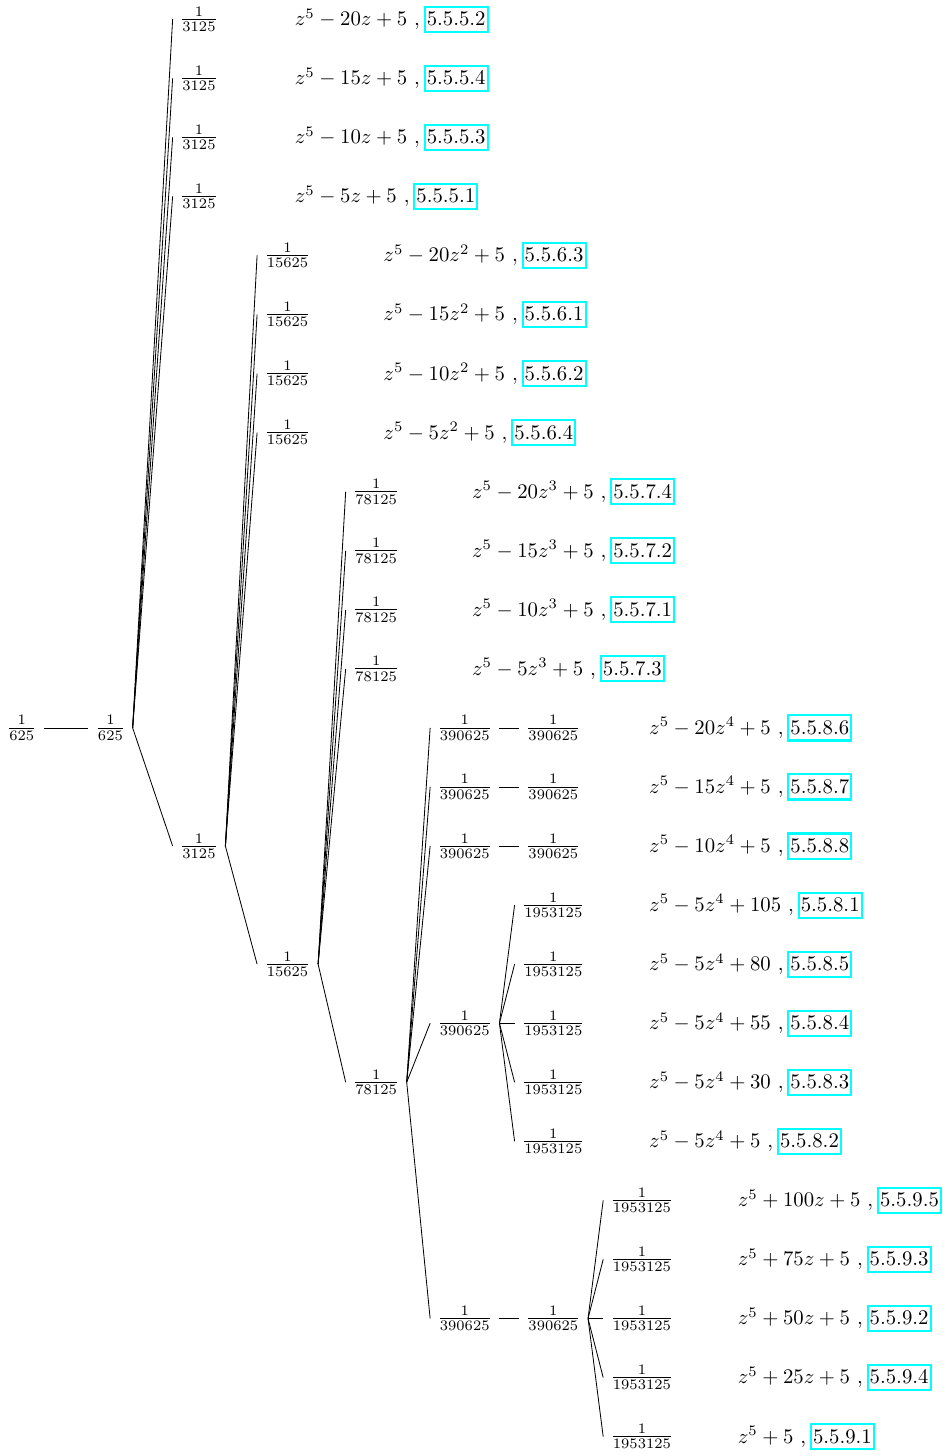

In [18]:
with open('latex/tree.tex', 'w') as tex:
    tex.write(printToTex(classTree))

!(cd latex; pdflatex tree.tex > /dev/null)
!(cd latex; pdftoppm -png tree.pdf > tree.png)

from IPython.display import Image
Image(filename='latex/tree.png') 

In [19]:
classTree

{'mass': 1/625,
 'length': 5,
 'children': [{'mass': 1/625,
   'length': 6,
   'eisenstein': z^5 + 5,
   'children': [{'mass': 1/3125,
     'length': 7,
     'eisenstein': z^5 + 5,
     'children': [{'mass': 1/15625,
       'length': 8,
       'eisenstein': z^5 + 5,
       'children': [{'mass': 1/78125,
         'length': 9,
         'eisenstein': z^5 + 5,
         'children': [{'mass': 1/390625,
           'length': 10,
           'eisenstein': z^5 + 5,
           'children': [{'mass': 1/390625,
             'length': 11,
             'eisenstein': z^5 + 5,
             'children': [{'mass': 1/1953125,
               'length': 12,
               'eisenstein': z^5 + 5,
               'children': [],
               'tag': '5.5.9.1'},
              {'mass': 1/1953125,
               'length': 12,
               'eisenstein': z^5 + 25*z + 5,
               'children': [],
               'tag': '5.5.9.4'},
              {'mass': 1/1953125,
               'length': 12,
               'eisen